In [1]:
import numpy as np
np.set_printoptions(suppress=True)
import time
from numba import njit,guvectorize,float64
import scipy.optimize as opt
from matplotlib import pyplot as plt
import math
#Set
t = np.arange(1, 101)
NT = len(t)

In [2]:
#Parameters
fosslim = 6000 # Maximum cumulative extraction fossil fuels (GtC); denoted by CCum
tstep  = 5 # Years per Period
ifopt  = 0 # Indicator where optimized is 1 and base is 0

In [3]:
#Preferences

elasmu = 1.45 #  Elasticity of marginal utility of consumption
prstp = 0.015 #   Initial rate of social time preference per year 

#** Population and technology
gama  = 0.300 #   Capital elasticity in production function         /.300 /
pop0  = 7403   # Initial world population 2015 (millions)          /7403 /
popadj = 0.134 #  Growth rate to calibrate to 2050 pop projection  /0.134/
popasym = 11500 # Asymptotic population (millions)                 /11500/
dk  = 0.100 #     Depreciation rate on capital (per year)           /.100 /
q0  = 105.5 #     Initial world gross output 2015 (trill 2010 USD) /105.5/
k0  = 223 #     Initial capital value 2015 (trill 2010 USD)        /223  /
a0  = 5.115 #     Initial level of total factor productivity       /5.115/
ga0  = 0.076 #    Initial growth rate for TFP per 5 years          /0.076/
dela  = 0.005 #   Decline rate of TFP per 5 years                  /0.005/

#** Emissions parameters
gsigma1  = -0.0152 # Initial growth of sigma (per year)            /-0.0152/
dsig  = -0.001 #   Decline rate of decarbonization (per period)    /-0.001 /
eland0 = 2.6 #  Carbon emissions from land 2015 (GtCO2 per year)   / 2.6   /
deland = 0.115 # Decline rate of land emissions (per period)        / .115  /
e0 = 35.85 #    Industrial emissions 2015 (GtCO2 per year)       /35.85  /
miu0  = 0.03 #   Initial emissions control rate for base case 2015  /.03    /

#** Carbon cycle
#* Initial Conditions
mat0 = 851 #  Initial Concentration in atmosphere 2015 (GtC)       /851  /
mu0  = 460 #  Initial Concentration in upper strata 2015 (GtC)     /460  /
ml0  = 1740 #  Initial Concentration in lower strata 2015 (GtC)    /1740 /
mateq = 588 # mateq Equilibrium concentration atmosphere  (GtC)    /588  /
mueq  = 360 # mueq Equilibrium concentration in upper strata (GtC) /360  /
mleq = 1720 # mleq Equilibrium concentration in lower strata (GtC) /1720 /

#* Flow paramaters, denoted by Phi_ij in the model
b12  = 0.12 #    Carbon cycle transition matrix                     /.12  /
b23  = 0.007 #   Carbon cycle transition matrix                    /0.007/
#* These are for declaration and are defined later
b11  = None   # Carbon cycle transition matrix
b21  = None  # Carbon cycle transition matrix
b22  = None  # Carbon cycle transition matrix
b32  = None  # Carbon cycle transition matrix
b33  = None  # Carbon cycle transition matrix
sig0  = None  # Carbon intensity 2010 (kgCO2 per output 2005 USD 2010)

#** Climate model parameters
t2xco2  = 3.1 # Equilibrium temp impact (oC per doubling CO2)    / 3.1 /
fex0  = 0.5 #   2015 forcings of non-CO2 GHG (Wm-2)              / 0.5 /
fex1  = 1.0 #   2100 forcings of non-CO2 GHG (Wm-2)              / 1.0 /
tocean0  = 0.0068 # Initial lower stratum temp change (C from 1900) /.0068/
tatm0  = 0.85 #  Initial atmospheric temp change (C from 1900)    /0.85/
c1  = 0.1005 #     Climate equation coefficient for upper level  /0.1005/
c3  = 0.088 #     Transfer coefficient upper to lower stratum    /0.088/
c4  = 0.025 #     Transfer coefficient for lower level           /0.025/
fco22x  = 3.6813 # eta in the model; Eq.22 : Forcings of equilibrium CO2 doubling (Wm-2)   /3.6813 /

#** Climate damage parameters
a10  = 0 #     Initial damage intercept                         /0   /
a20  = None #     Initial damage quadratic term
a1  = 0 #      Damage intercept                                 /0   /
a2  = 0.00236 #      Damage quadratic term                     /0.00236/
a3  = 2.00 #      Damage exponent                              /2.00   /

#** Abatement cost
expcost2 = 2.6 # Theta2 in the model, Eq. 10 Exponent of control cost function             / 2.6  /
pback  = 550 #   Cost of backstop 2010$ per tCO2 2015          / 550  /
gback  = 0.025 #   Initial cost decline backstop cost per period / .025/
limmiu  = 1.2 #  Upper limit on control rate after 2150        / 1.2 /
tnopol  = 45 #  Period before which no emissions controls base  / 45   /
cprice0  = 2 # Initial base carbon price (2010$ per tCO2)      / 2    /
gcprice  = 0.02 # Growth rate of base carbon price per year     /.02  /

#** Scaling and inessential parameters
#* Note that these are unnecessary for the calculations
#* They ensure that MU of first period's consumption =1 and PV cons = PV utilty
scale1  = 0.0302455265681763 #    Multiplicative scaling coefficient           /0.0302455265681763 /
scale2  = -10993.704 #    Additive scaling coefficient       /-10993.704/;

In [4]:
#* Parameters for long-run consistency of carbon cycle 
#(Question)
b11 = 1 - b12
b21 = b12*mateq/mueq
b22 = 1 - b21 - b23
b32 = b23*mueq/mleq
b33 = 1 - b32

#* Further definitions of parameters
a20 = a2
sig0 = e0/(q0*(1-miu0)) #From Eq. 14
lam = fco22x/ t2xco2 #From Eq. 25

l = np.zeros(NT)
l[0] = pop0 #Labor force
al = np.zeros(NT) 
al[0] = a0
gsig = np.zeros(NT) 
gsig[0] = gsigma1
sigma = np.zeros(NT)
sigma[0]= sig0
ga = ga0 * np.exp(-dela*5*(t-1)) #TFP growth rate dynamics, Eq. 7
pbacktime = pback * (1-gback)**(t-1) #Backstop price
etree = eland0*(1-deland)**(t-1) #Emissions from deforestration
rr = 1/((1+prstp)**(tstep*(t-1))) #Eq. 3
#The following three equations define the exogenous radiative forcing; used in Eq. 23  
forcoth = np.full(NT,fex0)
forcoth[0:18] = forcoth[0:18] + (1/17)*(fex1-fex0)*(t[0:18]-1)
forcoth[18:NT] = forcoth[18:NT] + (fex1-fex0)
optlrsav = (dk + .004)/(dk + .004*elasmu + prstp)*gama #Optimal long-run savings rate used for transversality (Question)
cost1 = np.zeros(NT)
cumetree = np.zeros(NT)
cumetree[0] = 100
cpricebase = cprice0*(1+gcprice)**(5*(t-1)) 

In [5]:
@njit('(float64[:], int32)')
def InitializeLabor(il,iNT):
    for i in range(1,iNT):
        il[i] = il[i-1]*(popasym / il[i-1])**popadj

@njit('(float64[:], int32)')        
def InitializeTFP(ial,iNT):
    for i in range(1,iNT):
        ial[i] = ial[i-1]/(1-ga[i-1])
        
@njit('(float64[:], int32)')        
def InitializeGrowthSigma(igsig,iNT):
    for i in range(1,iNT):
        igsig[i] = igsig[i-1]*((1+dsig)**tstep)
        
@njit('(float64[:], float64[:],float64[:],int32)')        
def InitializeSigma(isigma,igsig,icost1,iNT):
    for i in range(1,iNT):
        isigma[i] =  isigma[i-1] * np.exp(igsig[i-1] * tstep)
        icost1[i] = pbacktime[i] * isigma[i]  / expcost2 /1000
        
@njit('(float64[:], int32)')        
def InitializeCarbonTree(icumetree,iNT):
    for i in range(1,iNT):
        icumetree[i] = icumetree[i-1] + etree[i-1]*(5/3.666)


In [6]:
"""
Functions of the model
"""

"""
First: Functions related to emissions of carbon and weather damages
"""

# Retuns the total carbon emissions; Eq. 18
@njit('float64(float64[:],int32)') 
def fE(iEIND,index):
    return iEIND[index] + etree[index]

#Eq.14: Determines the emission of carbon by industry EIND
@njit('float64(float64[:],float64[:],float64[:],int32)') 
def fEIND(iYGROSS, iMIU, isigma,index):
    return isigma[index] * iYGROSS[index] * (1 - iMIU[index])

#Cumulative industrial emission of carbon
@njit('float64(float64[:],float64[:],int32)') 
def fCCA(iCCA,iEIND,index):
    return iCCA[index-1] + iEIND[index-1] * 5 / 3.666

#Cumulative total carbon emission
@njit('float64(float64[:],float64[:],int32)')
def fCCATOT(iCCA,icumetree,index):
    return iCCA[index] + icumetree[index]

#Eq. 22: the dynamics of the radiative forcing
@njit('float64(float64[:],int32)')
def fFORC(iMAT,index):
    return fco22x * np.log(iMAT[index]/588.000)/np.log(2) + forcoth[index]

# Dynamics of Omega; Eq.9
@njit('float64(float64[:],int32)')
def fDAMFRAC(iTATM,index):
    return a1*iTATM[index] + a2*iTATM[index]**a3

#Calculate damages as a function of Gross industrial production; Eq.8 
@njit('float64(float64[:],float64[:],int32)')
def fDAMAGES(iYGROSS,iDAMFRAC,index):
    return iYGROSS[index] * iDAMFRAC[index]

#Dynamics of Lambda; Eq. 10 - cost of the reudction of carbon emission (Abatement cost)
@njit('float64(float64[:],float64[:],float64[:],int32)') 
def fABATECOST(iYGROSS,iMIU,icost1,index):
    return iYGROSS[index] * icost1[index] * iMIU[index]**expcost2

#Marginal Abatement cost
@njit('float64(float64[:],int32)')
def fMCABATE(iMIU,index):
    return pbacktime[index] * iMIU[index]**(expcost2-1)

#Price of carbon reduction
@njit('float64(float64[:],int32)')
def fCPRICE(iMIU,index):
    return pbacktime[index] * (iMIU[index])**(expcost2-1)

#Eq. 19: Dynamics of the carbon concentration in the atmosphere
@njit('float64(float64[:],float64[:],float64[:],int32)') 
def fMAT(iMAT,iMU,iE,index):
    if(index == 0):
        return mat0
    else:
        return iMAT[index-1]*b11 + iMU[index-1]*b21 + iE[index-1] * 5 / 3.666

#Eq. 21: Dynamics of the carbon concentration in the ocean LOW level
@njit('float64(float64[:],float64[:],int32)') 
def fML(iML,iMU,index):
    if(index == 0):
        return ml0
    else:
        return iML[index-1] * b33  + iMU[index-1] * b23

#Eq. 20: Dynamics of the carbon concentration in the ocean UP level
@njit('float64(float64[:],float64[:],float64[:],int32)') 
def fMU(iMAT,iMU,iML,index):
    if(index == 0):
        return mu0
    else:
        return iMAT[index-1]*b12 + iMU[index-1]*b22 + iML[index-1]*b32

#Eq. 23: Dynamics of the atmospheric temperature
@njit('float64(float64[:],float64[:],float64[:],int32)') 
def fTATM(iTATM,iFORC,iTOCEAN,index):
    if(index == 0):
        return tatm0
    else:
        return iTATM[index-1] + c1 * (iFORC[index] - (fco22x/t2xco2) * iTATM[index-1] - c3 * (iTATM[index-1] - iTOCEAN[index-1]))

#Eq. 24: Dynamics of the ocean temperature
@njit('float64(float64[:],float64[:],int32)')
def fTOCEAN(iTATM,iTOCEAN,index):
    if(index == 0):
        return tocean0
    else:
        return iTOCEAN[index-1] + c4 * (iTATM[index-1] - iTOCEAN[index-1])

"""
Second: Function related to economic variables
"""

#The total production without climate losses denoted previously by YGROSS
@njit('float64(float64[:],float64[:],float64[:],int32)')
def fYGROSS(ial,il,iK,index):
    return ial[index] * ((il[index]/1000)**(1-gama)) * iK[index]**gama

#The production under the climate damages cost
@njit('float64(float64[:],float64[:],int32)')
def fYNET(iYGROSS, iDAMFRAC, index):
    return iYGROSS[index] * (1 - iDAMFRAC[index])

#Production after abatement cost
@njit('float64(float64[:],float64[:],int32)')
def fY(iYNET,iABATECOST,index):
    return iYNET[index] - iABATECOST[index]

#Consumption Eq. 11
@njit('float64(float64[:],float64[:],int32)')
def fC(iY,iI,index):
    return iY[index] - iI[index]

#Per capita consumption, Eq. 12
@njit('float64(float64[:],float64[:],int32)')
def fCPC(iC,il,index):
    return 1000 * iC[index] / il[index]

#Saving policy: investment
@njit('float64(float64[:],float64[:],int32)')
def fI(iS,iY,index):
    return iS[index] * iY[index] 

#Capital dynamics Eq. 13
@njit('float64(float64[:],float64[:],int32)')
def fK(iK,iI,index):
    if(index == 0):
        return k0
    else:
        return (1-dk)**tstep * iK[index-1] + tstep * iI[index-1]

#Interest rate equation; Eq. 26 added in personal notes
@njit('float64(float64[:],int32)')
def fRI(iCPC,index):
    return (1 + prstp) * (iCPC[index+1]/iCPC[index])**(elasmu/tstep) - 1

#Periodic utility: A form of Eq. 2
@njit('float64(float64[:],float64[:],int32)')
def fCEMUTOTPER(iPERIODU,il,index):
    return iPERIODU[index] * il[index] * rr[index]

#The term between brackets in Eq. 2
@njit('float64(float64[:],float64[:],int32)')
def fPERIODU(iC,il,index):
    return ((iC[index]*1000/il[index])**(1-elasmu) - 1) / (1 - elasmu) - 1

#utility function
@guvectorize([(float64[:], float64[:])], '(n), (m)')
def fUTILITY(iCEMUTOTPER, resUtility):
    resUtility[0] = tstep * scale1 * np.sum(iCEMUTOTPER) + scale2


In [7]:

"""
In this part we implement the objective function
"""

# * Control rate limits
MIU_lo = np.full(NT,0.01)
MIU_up = np.full(NT,limmiu)
MIU_up[0:29] = 1
MIU_lo[0] = miu0
MIU_up[0] = miu0
MIU_lo[MIU_lo==MIU_up] = 0.99999*MIU_lo[MIU_lo==MIU_up]
bnds1=[]
for i in range(NT):
    bnds1.append((MIU_lo[i],MIU_up[i]))
# * Control variables
lag10 = t > NT - 10
S_lo = np.full(NT,1e-1)
S_lo[lag10] = optlrsav
S_up = np.full(NT,0.9)
S_up[lag10] = optlrsav
S_lo[S_lo==S_up] = 0.99999*S_lo[S_lo==S_up]
bnds2=[]
for i in range(NT):
    bnds2.append((S_lo[i],S_up[i]))
    
# Arbitrary starting values for the control variables:
S_start = np.full(NT,0.2)
S_start[S_start < S_lo] = S_lo[S_start < S_lo]
S_start[S_start > S_up] = S_lo[S_start > S_up]
MIU_start = 0.99*MIU_up
MIU_start[MIU_start < MIU_lo] = MIU_lo[MIU_start < MIU_lo]
MIU_start[MIU_start > MIU_up] = MIU_up[MIU_start > MIU_up]

K = np.zeros(NT)
YGROSS = np.zeros(NT)
EIND = np.zeros(NT)
E = np.zeros(NT)
CCA = np.zeros(NT)
CCATOT = np.zeros(NT)
MAT = np.zeros(NT)
ML = np.zeros(NT)
MU = np.zeros(NT)
FORC = np.zeros(NT)
TATM = np.zeros(NT)
TOCEAN = np.zeros(NT)
DAMFRAC = np.zeros(NT)
DAMAGES = np.zeros(NT)
ABATECOST = np.zeros(NT)
MCABATE = np.zeros(NT)
CPRICE = np.zeros(NT)
YNET = np.zeros(NT)
Y = np.zeros(NT)
I = np.zeros(NT)
C = np.zeros(NT)
CPC = np.zeros(NT)
RI = np.zeros(NT)
PERIODU = np.zeros(NT)
CEMUTOTPER = np.zeros(NT)

In [8]:
#The objective function
#It returns the utility as scalar
def fOBJ(x,sign,iI,iK,ial,il,iYGROSS,isigma,iEIND,iE,iCCA,iCCATOT,icumetree,iMAT,iMU,iML,iFORC,iTATM,iTOCEAN,iDAMFRAC,iDAMAGES,iABATECOST,icost1,iMCABATE,
         iCPRICE,iYNET,iY,iC,iCPC,iPERIODU,iCEMUTOTPER,iRI,iNT):
    
    iMIU = x[0:iNT]
    iS = x[iNT:(2*iNT)]
    
    for i in range(iNT):
        iK[i] = fK(iK,iI,i)
        iYGROSS[i] = fYGROSS(ial,il,iK,i)
        iEIND[i] = fEIND(iYGROSS, iMIU, isigma,i)
        iE[i] = fE(iEIND,i)
        iCCA[i] = fCCA(iCCA,iEIND,i)
        iCCATOT[i] = fCCATOT(iCCA,icumetree,i)
        iMAT[i] = fMAT(iMAT,iMU,iE,i)
        iML[i] = fML(iML,iMU,i)
        iMU[i] = fMU(iMAT,iMU,iML,i)
        iFORC[i] = fFORC(iMAT,i)
        iTATM[i] = fTATM(iTATM,iFORC,iTOCEAN,i)
        iTOCEAN[i] = fTOCEAN(iTATM,iTOCEAN,i)
        iDAMFRAC[i] = fDAMFRAC(iTATM,i)
        iDAMAGES[i] = fDAMAGES(iYGROSS,iDAMFRAC,i)
        iABATECOST[i] = fABATECOST(iYGROSS,iMIU,icost1,i)
        iMCABATE[i] = fMCABATE(iMIU,i)
        iCPRICE[i] = fCPRICE(iMIU,i)
        iYNET[i] = fYNET(iYGROSS, iDAMFRAC, i)
        iY[i] = fY(iYNET,iABATECOST,i)
        iI[i] = fI(iS,iY,i)
        iC[i] = fC(iY,iI,i)
        iCPC[i] = fCPC(iC,il,i)
        iPERIODU[i] = fPERIODU(iC,il,i)
        iCEMUTOTPER[i] = fCEMUTOTPER(iPERIODU,il,i)
        iRI = fRI(iCPC,i)
        
    resUtility = np.zeros(1)
    fUTILITY(iCEMUTOTPER, resUtility)
    
    return sign*resUtility[0]

In [9]:
InitializeLabor(l,NT)
InitializeTFP(al,NT)
InitializeGrowthSigma(gsig,NT)
InitializeSigma(sigma,gsig,cost1,NT)
InitializeCarbonTree(cumetree,NT)

In [10]:
import tensorflow as tf
import numpy as np
import gym
import time
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
tfd = tfp.distributions

#####################  hyper parameters  ####################

MAX_EPISODES = 3000
MAX_EP_STEPS = 100
LR_A = 0.001    # learning rate for actor
LR_C = 0.002    # learning rate for critic
GAMMA = 0.9     # reward discount
TAU = 0.01      # soft replacement
MEMORY_CAPACITY = 10000
BATCH_SIZE = 32
n_agents = 1
ita = np.repeat(1/n_agents, n_agents, axis=0)

In [11]:
###############################  DDPG  ####################################

class DDPG(object):
    def __init__(self, a_dim, s_dim,):
        self.memory = np.zeros((MEMORY_CAPACITY, s_dim * 2 + a_dim + 1), dtype=np.float32)
        self.pointer = 0
        self.sess = tf.compat.v1.Session()

        self.a_dim, self.s_dim, = a_dim, s_dim, 
        tf.compat.v1.disable_eager_execution()
        self.S = tf.compat.v1.placeholder(tf.float32, [None, s_dim], 's')
        self.S_ = tf.compat.v1.placeholder(tf.float32, [None, s_dim], 's_')
        self.R = tf.compat.v1.placeholder(tf.float32, [None, 1], 'r')

        with tf.compat.v1.variable_scope('Actor'):
            self.a = self._build_a(self.S, scope='eval', trainable=True)
            a_ = self._build_a(self.S_, scope='target', trainable=False)
        with tf.compat.v1.variable_scope('Critic'):
            # assign self.a = a in memory when calculating q for td_error,
            # otherwise the self.a is from Actor when updating Actor
            q = self._build_c(self.S, self.a, scope='eval', trainable=True)
            q_ = self._build_c(self.S_, a_, scope='target', trainable=False)

        # networks parameters
        self.ae_params = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.GLOBAL_VARIABLES, scope='Actor/eval')
        self.at_params = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.GLOBAL_VARIABLES, scope='Actor/target')
        self.ce_params = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.GLOBAL_VARIABLES, scope='Critic/eval')
        self.ct_params = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.GLOBAL_VARIABLES, scope='Critic/target')

        # target net replacement
        self.soft_replace = [tf.compat.v1.assign(t, (1 - TAU) * t + TAU * e)
                             for t, e in zip(self.at_params + self.ct_params, self.ae_params + self.ce_params)]

        q_target = self.R + GAMMA * q_
        # in the feed_dic for the td_error, the self.a should change to actions in memory
        td_error = tf.compat.v1.losses.mean_squared_error(labels=q_target, predictions=q)
        self.ctrain = tf.compat.v1.train.AdamOptimizer(LR_C).minimize(td_error, var_list=self.ce_params)

        a_loss = -tf.reduce_mean(q)    # maximize the q
        self.atrain = tf.compat.v1.train.AdamOptimizer(LR_A).minimize(a_loss, var_list=self.ae_params)

        self.sess.run(tf.compat.v1.global_variables_initializer())

    def choose_action(self, s):
        return self.sess.run(self.a, {self.S: s[np.newaxis, :]})[0]

    def learn(self):
        # soft target replacement
        self.sess.run(self.soft_replace)

        indices = np.random.choice(MEMORY_CAPACITY, size=BATCH_SIZE)
        bt = self.memory[indices, :]
        bs = bt[:, :self.s_dim]
        ba = bt[:, self.s_dim: self.s_dim + self.a_dim]
        br = bt[:, -self.s_dim - 1: -self.s_dim]
        bs_ = bt[:, -self.s_dim:]

        self.sess.run(self.atrain, {self.S: bs})
        self.sess.run(self.ctrain, {self.S: bs, self.a: ba, self.R: br, self.S_: bs_})

    def store_transition(self, s, a, r, s_):
        transition = np.hstack((s, a, [r], s_))
        index = self.pointer % MEMORY_CAPACITY  # replace the old memory with new memory
        self.memory[index, :] = transition
        self.pointer += 1

    def _build_a(self, s, scope, trainable):
        with tf.compat.v1.variable_scope(scope):
            net = layers.Dense(3000, activation=tf.nn.relu, name='l1', trainable=trainable)(s)
            a = layers.Dense(self.a_dim, activation=tf.nn.tanh, name='a', trainable=trainable)(net)
            return a

    def _build_c(self, s, a, scope, trainable):
        with tf.compat.v1.variable_scope(scope):
            n_l1 = 3000
            w1_s = tf.compat.v1.get_variable('w1_s', [self.s_dim, n_l1], trainable=trainable)
            w1_a = tf.compat.v1.get_variable('w1_a', [self.a_dim, n_l1], trainable=trainable)
            b1 = tf.compat.v1.get_variable('b1', [1, n_l1], trainable=trainable)
            net = tf.nn.relu(tf.matmul(s, w1_s) + tf.matmul(a, w1_a) + b1)
            return layers.Dense(1, trainable=trainable)(net)  # Q(s,a)

In [12]:
class OPTIM(object):
    def __init__(self):
        super(OPTIM, self).__init__()
    
    def step(self, action):
        global x, x1, x2
            
        miu = np.sum(np.multiply(action[:n_agents], ita))
        s = np.sum(np.multiply(action[-n_agents:], ita))
        x1 = np.append(x1, miu)
        x2 = np.append(x2, s)
        x = np.concatenate([x1,x2])
        obs_ = np.concatenate([action, ita])
        #obs_ = np.array([miu,s,steps+1])
        
        reward = fOBJ(x,1,I,K,al,l,YGROSS,sigma,EIND,E,CCA,CCATOT,cumetree,MAT,MU,ML,FORC,TATM,TOCEAN,DAMFRAC,DAMAGES,ABATECOST,cost1,MCABATE,
         CPRICE,YNET,Y,C,CPC,PERIODU,CEMUTOTPER,RI,j+1)
        #if reward == np.nan:
            #reward = 0
            
        done = bool(j==99)
        #if done == True:
            #if reward > 4500:
             #   R = 2
            #else:
            #    R = 1
        #else:
            #R = 0
        return obs_, reward, done
        
    def reset(self):
        return np.concatenate([np.repeat([MIU_start[0],S_start[0]], n_agents, axis=0), ita])
        #return np.array([MIU_start[0],S_start[0],0])


In [13]:
###############################  training  ####################################
import random
random.seed(42)

env = OPTIM()

s_dim = n_agents*3
a_dim = n_agents*2

ddpg = DDPG(a_dim, s_dim)

var = 3  # control exploration
t1 = time.time()
episode_count = 0
Reward = []
epi = []

for i in range(MAX_EPISODES):
    s = env.reset()
    ep_reward = 0
    x1 = []
    x2 = []
    
    for j in range(MAX_EP_STEPS):
        x = []
        
        # Add exploration noise
        a = ddpg.choose_action(s)
        
        for k in range(a_dim):
            if k < n_agents:
                a[k] = np.clip(np.random.normal(a[k], var), MIU_lo[j], MIU_up[j]) 
            else:
                a[k] = np.clip(np.random.normal(a[k], var), S_lo[j], S_up[j]) 
       
        s_, r, done = env.step(a)

        ddpg.store_transition(s, a, r, s_)

        if ddpg.pointer > MEMORY_CAPACITY:
            var *= .9995    # decay the action randomness
            ddpg.learn()

        s = s_
        ep_reward += r
        if j == MAX_EP_STEPS-1:
            print('Episode:', i, ' Reward: %i' % int(ep_reward), 'Explore: %.2f' % var, 'current reward', r)
            break
    if r > 4500:
        print('Problem solved!')
            
    episode_count += 1
    Reward.append(r)
    epi.append(episode_count)
print('Running time: ', time.time() - t1)

Episode: 0  Reward: -199939 Explore: 3.00 current reward 277.1104877289581
Episode: 1  Reward: -37078 Explore: 3.00 current reward -472.21488734951527
Episode: 2  Reward: 130631 Explore: 3.00 current reward 1408.1101645758536
Episode: 3  Reward: -80234 Explore: 3.00 current reward -974.6647678987374
Episode: 4  Reward: -32173 Explore: 3.00 current reward -244.97744947201318
Episode: 5  Reward: 25665 Explore: 3.00 current reward 193.08403217947125
Episode: 6  Reward: -208307 Explore: 3.00 current reward -2067.713110744491
Episode: 7  Reward: -271008 Explore: 3.00 current reward -2692.624412051455
Episode: 8  Reward: -134470 Explore: 3.00 current reward -1286.5127319912535
Episode: 9  Reward: -189915 Explore: 3.00 current reward -1886.7235006265419
Episode: 10  Reward: 67786 Explore: 3.00 current reward 674.2937926661489
Episode: 11  Reward: 40920 Explore: 3.00 current reward 530.9553981728131
Episode: 12  Reward: -15391 Explore: 3.00 current reward -326.83295911013374
Episode: 13  Rewar

Episode: 109  Reward: 116623 Explore: 1.82 current reward 1123.0946339288694
Episode: 110  Reward: 289973 Explore: 1.73 current reward 3056.1194990458607
Episode: 111  Reward: 289820 Explore: 1.65 current reward 2893.0619401890963
Episode: 112  Reward: 329463 Explore: 1.57 current reward 3241.4313256695805
Episode: 113  Reward: 100827 Explore: 1.49 current reward 1045.4635200411649
Episode: 114  Reward: 161232 Explore: 1.42 current reward 1592.449491068639
Episode: 115  Reward: 282120 Explore: 1.35 current reward 2782.708890725542
Episode: 116  Reward: 354530 Explore: 1.28 current reward 3610.4280859720293
Episode: 117  Reward: 282107 Explore: 1.22 current reward 2767.2560455231087
Episode: 118  Reward: 267477 Explore: 1.16 current reward 2770.887524124397
Episode: 119  Reward: 388976 Explore: 1.10 current reward 3882.258965194127
Episode: 120  Reward: 283686 Explore: 1.05 current reward 2765.209573518907
Episode: 121  Reward: 368108 Explore: 1.00 current reward 3735.7937743591374
Epis

Episode: 217  Reward: 121707 Explore: 0.01 current reward 1202.5392862776462
Episode: 218  Reward: 142143 Explore: 0.01 current reward 1446.0843732428311
Episode: 219  Reward: 156607 Explore: 0.01 current reward 1560.9031911445418
Episode: 220  Reward: 150636 Explore: 0.01 current reward 1501.5302929192512
Episode: 221  Reward: 93550 Explore: 0.01 current reward 829.6577007488522
Episode: 222  Reward: 123551 Explore: 0.01 current reward 1329.9052608192596
Episode: 223  Reward: 125400 Explore: 0.01 current reward 1251.7139139838728
Episode: 224  Reward: 132508 Explore: 0.01 current reward 1326.4730364180468
Episode: 225  Reward: 118816 Explore: 0.01 current reward 1166.5945135374059
Episode: 226  Reward: 115369 Explore: 0.01 current reward 1149.8728573057033
Episode: 227  Reward: 98418 Explore: 0.00 current reward 946.6274400283291
Episode: 228  Reward: 117594 Explore: 0.00 current reward 1229.5007554650947
Episode: 229  Reward: 122335 Explore: 0.00 current reward 1233.6693319212263
Epi

Episode: 324  Reward: 140207 Explore: 0.00 current reward 1400.5122324178737
Episode: 325  Reward: 137027 Explore: 0.00 current reward 1374.4606644057603
Episode: 326  Reward: 138987 Explore: 0.00 current reward 1391.1802117010502
Episode: 327  Reward: 144049 Explore: 0.00 current reward 1444.9078734588602
Episode: 328  Reward: 160285 Explore: 0.00 current reward 1609.3196306052087
Episode: 329  Reward: 158630 Explore: 0.00 current reward 1596.3217149024476
Episode: 330  Reward: 148948 Explore: 0.00 current reward 1473.4972963266828
Episode: 331  Reward: 201209 Explore: 0.00 current reward 2054.8891263388105
Episode: 332  Reward: 209833 Explore: 0.00 current reward 2115.547239549396
Episode: 333  Reward: 245492 Explore: 0.00 current reward 2479.8898876297753
Episode: 334  Reward: 243666 Explore: 0.00 current reward 2428.8896397826993
Episode: 335  Reward: 257811 Explore: 0.00 current reward 2590.573370334285
Episode: 336  Reward: 271942 Explore: 0.00 current reward 2726.491106314663
Ep

Episode: 431  Reward: 291496 Explore: 0.00 current reward 2915.975835440615
Episode: 432  Reward: 295089 Explore: 0.00 current reward 2951.287174900315
Episode: 433  Reward: 292602 Explore: 0.00 current reward 2925.8714021248234
Episode: 434  Reward: 291045 Explore: 0.00 current reward 2910.6315720453604
Episode: 435  Reward: 293614 Explore: 0.00 current reward 2936.5755044412927
Episode: 436  Reward: 292387 Explore: 0.00 current reward 2923.9226536478
Episode: 437  Reward: 298487 Explore: 0.00 current reward 2985.8955610840258
Episode: 438  Reward: 296475 Explore: 0.00 current reward 2965.392365394273
Episode: 439  Reward: 296722 Explore: 0.00 current reward 2967.128027206416
Episode: 440  Reward: 300384 Explore: 0.00 current reward 3004.3778065872502
Episode: 441  Reward: 298416 Explore: 0.00 current reward 2983.971665834377
Episode: 442  Reward: 302002 Explore: 0.00 current reward 3020.614733576005
Episode: 443  Reward: 296666 Explore: 0.00 current reward 2966.3972618035477
Episode:

Episode: 539  Reward: 360165 Explore: 0.00 current reward 3601.826558707082
Episode: 540  Reward: 362359 Explore: 0.00 current reward 3623.5505657095346
Episode: 541  Reward: 357695 Explore: 0.00 current reward 3576.7803015513527
Episode: 542  Reward: 364963 Explore: 0.00 current reward 3649.742689359082
Episode: 543  Reward: 364302 Explore: 0.00 current reward 3643.058090516288
Episode: 544  Reward: 362584 Explore: 0.00 current reward 3625.8755950079103
Episode: 545  Reward: 366007 Explore: 0.00 current reward 3660.0728463157957
Episode: 546  Reward: 364508 Explore: 0.00 current reward 3645.0438727696037
Episode: 547  Reward: 365295 Explore: 0.00 current reward 3652.9791970574697
Episode: 548  Reward: 368963 Explore: 0.00 current reward 3689.6771152827823
Episode: 549  Reward: 367480 Explore: 0.00 current reward 3674.8759775183607
Episode: 550  Reward: 366833 Explore: 0.00 current reward 3668.2414697222066
Episode: 551  Reward: 364966 Explore: 0.00 current reward 3649.708979449384
Epi

Episode: 647  Reward: 411550 Explore: 0.00 current reward 4115.393929894539
Episode: 648  Reward: 412624 Explore: 0.00 current reward 4126.194101525973
Episode: 649  Reward: 412725 Explore: 0.00 current reward 4127.2188495754635
Episode: 650  Reward: 412796 Explore: 0.00 current reward 4127.919060322034
Episode: 651  Reward: 413067 Explore: 0.00 current reward 4130.714066587605
Episode: 652  Reward: 412981 Explore: 0.00 current reward 4129.782582515349
Episode: 653  Reward: 414617 Explore: 0.00 current reward 4146.074356295223
Episode: 654  Reward: 414012 Explore: 0.00 current reward 4140.17215016411
Episode: 655  Reward: 413360 Explore: 0.00 current reward 4133.620549995361
Episode: 656  Reward: 414916 Explore: 0.00 current reward 4149.0911514847485
Episode: 657  Reward: 415395 Explore: 0.00 current reward 4153.988391502937
Episode: 658  Reward: 415134 Explore: 0.00 current reward 4151.165786562175
Episode: 659  Reward: 416132 Explore: 0.00 current reward 4161.337117867661
Episode: 66

Episode: 755  Reward: 434416 Explore: 0.00 current reward 4344.236850147303
Episode: 756  Reward: 434532 Explore: 0.00 current reward 4344.979731519872
Episode: 757  Reward: 434405 Explore: 0.00 current reward 4344.177229627256
Episode: 758  Reward: 434721 Explore: 0.00 current reward 4347.094335007645
Episode: 759  Reward: 434925 Explore: 0.00 current reward 4349.162467919237
Episode: 760  Reward: 434900 Explore: 0.00 current reward 4349.070371922149
Episode: 761  Reward: 435144 Explore: 0.00 current reward 4351.193549341508
Episode: 762  Reward: 434958 Explore: 0.00 current reward 4349.8385188120865
Episode: 763  Reward: 435315 Explore: 0.00 current reward 4352.760051084175
Episode: 764  Reward: 435370 Explore: 0.00 current reward 4353.8238226619305
Episode: 765  Reward: 435329 Explore: 0.00 current reward 4353.273231783991
Episode: 766  Reward: 435467 Explore: 0.00 current reward 4354.583750041507
Episode: 767  Reward: 435490 Explore: 0.00 current reward 4354.7139455052
Episode: 768

Episode: 863  Reward: 438057 Explore: 0.00 current reward 4380.926467458803
Episode: 864  Reward: 438168 Explore: 0.00 current reward 4381.051406439039
Episode: 865  Reward: 438129 Explore: 0.00 current reward 4381.224623364142
Episode: 866  Reward: 438208 Explore: 0.00 current reward 4382.016887759775
Episode: 867  Reward: 438179 Explore: 0.00 current reward 4382.314565396657
Episode: 868  Reward: 438112 Explore: 0.00 current reward 4381.156154832821
Episode: 869  Reward: 438253 Explore: 0.00 current reward 4382.210380982106
Episode: 870  Reward: 438302 Explore: 0.00 current reward 4383.013633585053
Episode: 871  Reward: 438254 Explore: 0.00 current reward 4382.580663843828
Episode: 872  Reward: 438203 Explore: 0.00 current reward 4382.0343624475645
Episode: 873  Reward: 438064 Explore: 0.00 current reward 4381.1958735592925
Episode: 874  Reward: 438019 Explore: 0.00 current reward 4380.293050336333
Episode: 875  Reward: 438103 Explore: 0.00 current reward 4380.730794468775
Episode: 8

Episode: 971  Reward: 438084 Explore: 0.00 current reward 4380.585075062527
Episode: 972  Reward: 438028 Explore: 0.00 current reward 4380.434377315578
Episode: 973  Reward: 438101 Explore: 0.00 current reward 4380.809696630613
Episode: 974  Reward: 438000 Explore: 0.00 current reward 4380.127488892
Episode: 975  Reward: 438038 Explore: 0.00 current reward 4380.348124678851
Episode: 976  Reward: 438034 Explore: 0.00 current reward 4380.221851035965
Episode: 977  Reward: 438068 Explore: 0.00 current reward 4380.68539377663
Episode: 978  Reward: 437969 Explore: 0.00 current reward 4379.847239125782
Episode: 979  Reward: 437898 Explore: 0.00 current reward 4379.144963657491
Episode: 980  Reward: 438131 Explore: 0.00 current reward 4380.719949483129
Episode: 981  Reward: 438058 Explore: 0.00 current reward 4380.545589704139
Episode: 982  Reward: 438052 Explore: 0.00 current reward 4380.574643016829
Episode: 983  Reward: 438174 Explore: 0.00 current reward 4380.97826792181
Episode: 984  Rew

Episode: 1078  Reward: 446575 Explore: 0.00 current reward 4466.009682087431
Episode: 1079  Reward: 446824 Explore: 0.00 current reward 4468.105408600082
Episode: 1080  Reward: 446964 Explore: 0.00 current reward 4469.505495923409
Episode: 1081  Reward: 446714 Explore: 0.00 current reward 4467.452811686508
Episode: 1082  Reward: 446996 Explore: 0.00 current reward 4469.674102324278
Episode: 1083  Reward: 446763 Explore: 0.00 current reward 4467.83102813985
Episode: 1084  Reward: 447093 Explore: 0.00 current reward 4470.59838219684
Episode: 1085  Reward: 446867 Explore: 0.00 current reward 4468.854159671117
Episode: 1086  Reward: 447047 Explore: 0.00 current reward 4470.284389873548
Episode: 1087  Reward: 446918 Explore: 0.00 current reward 4469.369720467392
Episode: 1088  Reward: 447177 Explore: 0.00 current reward 4471.380391088358
Episode: 1089  Reward: 447174 Explore: 0.00 current reward 4471.798298372467
Episode: 1090  Reward: 447176 Explore: 0.00 current reward 4471.642412273533
E

Episode: 1185  Reward: 447327 Explore: 0.00 current reward 4473.489742776117
Episode: 1186  Reward: 447323 Explore: 0.00 current reward 4473.37017460011
Episode: 1187  Reward: 447263 Explore: 0.00 current reward 4473.093074181455
Episode: 1188  Reward: 447264 Explore: 0.00 current reward 4472.746982622155
Episode: 1189  Reward: 447315 Explore: 0.00 current reward 4472.994683680932
Episode: 1190  Reward: 447263 Explore: 0.00 current reward 4472.892915344544
Episode: 1191  Reward: 447381 Explore: 0.00 current reward 4473.364495405578
Episode: 1192  Reward: 447366 Explore: 0.00 current reward 4473.621886888974
Episode: 1193  Reward: 447322 Explore: 0.00 current reward 4473.313035323508
Episode: 1194  Reward: 447385 Explore: 0.00 current reward 4473.55363697107
Episode: 1195  Reward: 447296 Explore: 0.00 current reward 4473.219306194416
Episode: 1196  Reward: 447353 Explore: 0.00 current reward 4473.451293480361
Episode: 1197  Reward: 447299 Explore: 0.00 current reward 4473.200580637631
E

Episode: 1292  Reward: 447307 Explore: 0.00 current reward 4473.070692512947
Episode: 1293  Reward: 447314 Explore: 0.00 current reward 4473.113783476423
Episode: 1294  Reward: 447309 Explore: 0.00 current reward 4473.098583508614
Episode: 1295  Reward: 447849 Explore: 0.00 current reward 4479.286838408041
Episode: 1296  Reward: 447873 Explore: 0.00 current reward 4478.442336220271
Episode: 1297  Reward: 447888 Explore: 0.00 current reward 4479.203745760624
Episode: 1298  Reward: 448006 Explore: 0.00 current reward 4480.966785680666
Episode: 1299  Reward: 448126 Explore: 0.00 current reward 4482.054858522886
Episode: 1300  Reward: 448230 Explore: 0.00 current reward 4483.336533336298
Episode: 1301  Reward: 448496 Explore: 0.00 current reward 4485.721796543419
Episode: 1302  Reward: 448830 Explore: 0.00 current reward 4488.408077113998
Episode: 1303  Reward: 449021 Explore: 0.00 current reward 4490.338578813475
Episode: 1304  Reward: 448296 Explore: 0.00 current reward 4480.44824286563


Episode: 1399  Reward: 449877 Explore: 0.00 current reward 4499.012385654127
Episode: 1400  Reward: 449979 Explore: 0.00 current reward 4499.257790802909
Episode: 1401  Reward: 449924 Explore: 0.00 current reward 4499.1756241443745
Episode: 1402  Reward: 449945 Explore: 0.00 current reward 4499.64202810817
Episode: 1403  Reward: 449916 Explore: 0.00 current reward 4498.527315069365
Episode: 1404  Reward: 449830 Explore: 0.00 current reward 4499.141723900797
Episode: 1405  Reward: 449930 Explore: 0.00 current reward 4499.23826874939
Episode: 1406  Reward: 449881 Explore: 0.00 current reward 4498.847026559619
Episode: 1407  Reward: 449929 Explore: 0.00 current reward 4499.407284359666
Episode: 1408  Reward: 449920 Explore: 0.00 current reward 4499.345566694665
Episode: 1409  Reward: 449931 Explore: 0.00 current reward 4499.536947567871
Episode: 1410  Reward: 449811 Explore: 0.00 current reward 4498.10014147211
Episode: 1411  Reward: 449936 Explore: 0.00 current reward 4499.248074532414
E

Episode: 1503  Reward: 450012 Explore: 0.00 current reward 4500.3364461958245
Problem solved!
Episode: 1504  Reward: 449962 Explore: 0.00 current reward 4499.8521963181665
Episode: 1505  Reward: 449939 Explore: 0.00 current reward 4499.5730576819915
Episode: 1506  Reward: 450008 Explore: 0.00 current reward 4499.882689814209
Episode: 1507  Reward: 449977 Explore: 0.00 current reward 4499.641761387569
Episode: 1508  Reward: 449921 Explore: 0.00 current reward 4498.979718241502
Episode: 1509  Reward: 449931 Explore: 0.00 current reward 4499.680660501435
Episode: 1510  Reward: 449975 Explore: 0.00 current reward 4499.877505722832
Episode: 1511  Reward: 449941 Explore: 0.00 current reward 4498.851111874101
Episode: 1512  Reward: 449914 Explore: 0.00 current reward 4499.991348894053
Episode: 1513  Reward: 450000 Explore: 0.00 current reward 4499.623581260566
Episode: 1514  Reward: 449962 Explore: 0.00 current reward 4499.873651019168
Episode: 1515  Reward: 449984 Explore: 0.00 current rewar

Episode: 1604  Reward: 449860 Explore: 0.00 current reward 4498.235142441359
Episode: 1605  Reward: 450051 Explore: 0.00 current reward 4500.327820776469
Problem solved!
Episode: 1606  Reward: 450017 Explore: 0.00 current reward 4500.34852604924
Problem solved!
Episode: 1607  Reward: 449948 Explore: 0.00 current reward 4499.363222578748
Episode: 1608  Reward: 450017 Explore: 0.00 current reward 4500.29271247111
Problem solved!
Episode: 1609  Reward: 449947 Explore: 0.00 current reward 4499.4858692442795
Episode: 1610  Reward: 449933 Explore: 0.00 current reward 4499.228595390237
Episode: 1611  Reward: 449746 Explore: 0.00 current reward 4497.336451031959
Episode: 1612  Reward: 450083 Explore: 0.00 current reward 4501.5534707269435
Problem solved!
Episode: 1613  Reward: 449690 Explore: 0.00 current reward 4496.271244933852
Episode: 1614  Reward: 449545 Explore: 0.00 current reward 4495.785006434722
Episode: 1615  Reward: 449735 Explore: 0.00 current reward 4497.857116947918
Episode: 161

Episode: 1704  Reward: 450075 Explore: 0.00 current reward 4499.693442012671
Episode: 1705  Reward: 450052 Explore: 0.00 current reward 4500.852847303269
Problem solved!
Episode: 1706  Reward: 450019 Explore: 0.00 current reward 4500.501321106534
Problem solved!
Episode: 1707  Reward: 449983 Explore: 0.00 current reward 4499.985126887761
Episode: 1708  Reward: 449919 Explore: 0.00 current reward 4499.7224217812745
Episode: 1709  Reward: 449928 Explore: 0.00 current reward 4499.748522257965
Episode: 1710  Reward: 449944 Explore: 0.00 current reward 4499.460234866852
Episode: 1711  Reward: 449933 Explore: 0.00 current reward 4499.144281912539
Episode: 1712  Reward: 449919 Explore: 0.00 current reward 4498.6221576724
Episode: 1713  Reward: 449912 Explore: 0.00 current reward 4499.188772875737
Episode: 1714  Reward: 449979 Explore: 0.00 current reward 4499.876755197829
Episode: 1715  Reward: 449808 Explore: 0.00 current reward 4498.540828927904
Episode: 1716  Reward: 449713 Explore: 0.00 c

Episode: 1806  Reward: 449920 Explore: 0.00 current reward 4499.225579517179
Episode: 1807  Reward: 449908 Explore: 0.00 current reward 4499.589186278219
Episode: 1808  Reward: 450000 Explore: 0.00 current reward 4499.145782938142
Episode: 1809  Reward: 449965 Explore: 0.00 current reward 4499.105706241831
Episode: 1810  Reward: 449936 Explore: 0.00 current reward 4500.050346992366
Problem solved!
Episode: 1811  Reward: 449843 Explore: 0.00 current reward 4498.274743109841
Episode: 1812  Reward: 449919 Explore: 0.00 current reward 4498.9901339201515
Episode: 1813  Reward: 449964 Explore: 0.00 current reward 4499.831096828566
Episode: 1814  Reward: 449807 Explore: 0.00 current reward 4497.395863547739
Episode: 1815  Reward: 449783 Explore: 0.00 current reward 4497.754724609211
Episode: 1816  Reward: 449717 Explore: 0.00 current reward 4497.45893141874
Episode: 1817  Reward: 449858 Explore: 0.00 current reward 4499.035108698361
Episode: 1818  Reward: 449974 Explore: 0.00 current reward 4

Episode: 1912  Reward: 449951 Explore: 0.00 current reward 4499.43598077754
Episode: 1913  Reward: 449891 Explore: 0.00 current reward 4498.8494769516055
Episode: 1914  Reward: 449937 Explore: 0.00 current reward 4499.100613929342
Episode: 1915  Reward: 449969 Explore: 0.00 current reward 4499.7378380904665
Episode: 1916  Reward: 449971 Explore: 0.00 current reward 4499.32499488814
Episode: 1917  Reward: 449922 Explore: 0.00 current reward 4499.357070291282
Episode: 1918  Reward: 449867 Explore: 0.00 current reward 4499.563047029427
Episode: 1919  Reward: 449946 Explore: 0.00 current reward 4499.060830893446
Episode: 1920  Reward: 450062 Explore: 0.00 current reward 4499.207012606901
Episode: 1921  Reward: 449885 Explore: 0.00 current reward 4499.670575787994
Episode: 1922  Reward: 449848 Explore: 0.00 current reward 4498.827357317026
Episode: 1923  Reward: 449961 Explore: 0.00 current reward 4499.693699884139
Episode: 1924  Reward: 450037 Explore: 0.00 current reward 4500.362622298393

Episode: 2017  Reward: 449901 Explore: 0.00 current reward 4498.783807107166
Episode: 2018  Reward: 449898 Explore: 0.00 current reward 4499.027501828625
Episode: 2019  Reward: 449950 Explore: 0.00 current reward 4498.860249887815
Episode: 2020  Reward: 450004 Explore: 0.00 current reward 4499.821389785169
Episode: 2021  Reward: 449726 Explore: 0.00 current reward 4498.484083277506
Episode: 2022  Reward: 449897 Explore: 0.00 current reward 4498.748592139116
Episode: 2023  Reward: 449874 Explore: 0.00 current reward 4498.735627769489
Episode: 2024  Reward: 449955 Explore: 0.00 current reward 4499.428495352211
Episode: 2025  Reward: 449911 Explore: 0.00 current reward 4498.605131717195
Episode: 2026  Reward: 449938 Explore: 0.00 current reward 4498.745691081567
Episode: 2027  Reward: 449674 Explore: 0.00 current reward 4498.341489547165
Episode: 2028  Reward: 450043 Explore: 0.00 current reward 4498.496619644218
Episode: 2029  Reward: 449884 Explore: 0.00 current reward 4499.190439606027

Episode: 2123  Reward: 449881 Explore: 0.00 current reward 4498.586763817157
Episode: 2124  Reward: 449859 Explore: 0.00 current reward 4498.833155884224
Episode: 2125  Reward: 449875 Explore: 0.00 current reward 4498.479425818772
Episode: 2126  Reward: 449840 Explore: 0.00 current reward 4498.338373313751
Episode: 2127  Reward: 449778 Explore: 0.00 current reward 4497.800286924115
Episode: 2128  Reward: 449833 Explore: 0.00 current reward 4497.6793989084435
Episode: 2129  Reward: 449732 Explore: 0.00 current reward 4496.958435366014
Episode: 2130  Reward: 449745 Explore: 0.00 current reward 4499.058715679439
Episode: 2131  Reward: 449839 Explore: 0.00 current reward 4497.51444902567
Episode: 2132  Reward: 449723 Explore: 0.00 current reward 4498.30651728735
Episode: 2133  Reward: 449803 Explore: 0.00 current reward 4499.257926008973
Episode: 2134  Reward: 449935 Explore: 0.00 current reward 4498.728564337098
Episode: 2135  Reward: 449935 Explore: 0.00 current reward 4498.146336653041


Episode: 2230  Reward: 449754 Explore: 0.00 current reward 4498.051237530695
Episode: 2231  Reward: 449630 Explore: 0.00 current reward 4496.618208456241
Episode: 2232  Reward: 449737 Explore: 0.00 current reward 4497.240637987959
Episode: 2233  Reward: 449710 Explore: 0.00 current reward 4497.680163238254
Episode: 2234  Reward: 449771 Explore: 0.00 current reward 4497.922110828396
Episode: 2235  Reward: 449846 Explore: 0.00 current reward 4497.164808632728
Episode: 2236  Reward: 449736 Explore: 0.00 current reward 4497.5589917623365
Episode: 2237  Reward: 449720 Explore: 0.00 current reward 4496.802062693514
Episode: 2238  Reward: 449788 Explore: 0.00 current reward 4498.318719598636
Episode: 2239  Reward: 449599 Explore: 0.00 current reward 4497.443374353939
Episode: 2240  Reward: 449722 Explore: 0.00 current reward 4497.09889434445
Episode: 2241  Reward: 449814 Explore: 0.00 current reward 4498.198307233362
Episode: 2242  Reward: 449649 Explore: 0.00 current reward 4497.407438795781

Episode: 2336  Reward: 449838 Explore: 0.00 current reward 4498.3378801581675
Episode: 2337  Reward: 449852 Explore: 0.00 current reward 4498.5110311692315
Episode: 2338  Reward: 449847 Explore: 0.00 current reward 4498.394029281635
Episode: 2339  Reward: 449807 Explore: 0.00 current reward 4498.110555192996
Episode: 2340  Reward: 449830 Explore: 0.00 current reward 4498.302502179775
Episode: 2341  Reward: 449807 Explore: 0.00 current reward 4498.023382636869
Episode: 2342  Reward: 449818 Explore: 0.00 current reward 4498.013805145398
Episode: 2343  Reward: 449717 Explore: 0.00 current reward 4497.785523444412
Episode: 2344  Reward: 449862 Explore: 0.00 current reward 4498.41727648778
Episode: 2345  Reward: 449809 Explore: 0.00 current reward 4497.965917576148
Episode: 2346  Reward: 449822 Explore: 0.00 current reward 4498.137555959169
Episode: 2347  Reward: 449797 Explore: 0.00 current reward 4497.968235999948
Episode: 2348  Reward: 449773 Explore: 0.00 current reward 4497.74910876401

Episode: 2443  Reward: 449493 Explore: 0.00 current reward 4495.161408800028
Episode: 2444  Reward: 449330 Explore: 0.00 current reward 4493.4286126974075
Episode: 2445  Reward: 449403 Explore: 0.00 current reward 4493.866116725425
Episode: 2446  Reward: 449407 Explore: 0.00 current reward 4494.187722371515
Episode: 2447  Reward: 449479 Explore: 0.00 current reward 4494.713573721956
Episode: 2448  Reward: 449450 Explore: 0.00 current reward 4494.309299489867
Episode: 2449  Reward: 449532 Explore: 0.00 current reward 4495.281664177421
Episode: 2450  Reward: 449537 Explore: 0.00 current reward 4495.40935219827
Episode: 2451  Reward: 449282 Explore: 0.00 current reward 4493.303662435341
Episode: 2452  Reward: 449548 Explore: 0.00 current reward 4495.062684996456
Episode: 2453  Reward: 449409 Explore: 0.00 current reward 4494.199735609323
Episode: 2454  Reward: 449748 Explore: 0.00 current reward 4496.748101474024
Episode: 2455  Reward: 449573 Explore: 0.00 current reward 4496.017820939436

Episode: 2548  Reward: 450026 Explore: 0.00 current reward 4500.155252661158
Problem solved!
Episode: 2549  Reward: 450032 Explore: 0.00 current reward 4500.430702346828
Problem solved!
Episode: 2550  Reward: 450057 Explore: 0.00 current reward 4500.505728974471
Problem solved!
Episode: 2551  Reward: 450019 Explore: 0.00 current reward 4500.19759622779
Problem solved!
Episode: 2552  Reward: 450033 Explore: 0.00 current reward 4500.3157511817735
Problem solved!
Episode: 2553  Reward: 450050 Explore: 0.00 current reward 4500.404462226465
Problem solved!
Episode: 2554  Reward: 450043 Explore: 0.00 current reward 4500.3659562529665
Problem solved!
Episode: 2555  Reward: 450074 Explore: 0.00 current reward 4500.820017200262
Problem solved!
Episode: 2556  Reward: 450028 Explore: 0.00 current reward 4500.288830290765
Problem solved!
Episode: 2557  Reward: 450067 Explore: 0.00 current reward 4500.564291858651
Problem solved!
Episode: 2558  Reward: 450047 Explore: 0.00 current reward 4500.49301

Episode: 2637  Reward: 450011 Explore: 0.00 current reward 4499.772282449761
Episode: 2638  Reward: 450082 Explore: 0.00 current reward 4500.551689395492
Problem solved!
Episode: 2639  Reward: 449817 Explore: 0.00 current reward 4499.198686331314
Episode: 2640  Reward: 449919 Explore: 0.00 current reward 4498.7527736410775
Episode: 2641  Reward: 450052 Explore: 0.00 current reward 4500.819284232766
Problem solved!
Episode: 2642  Reward: 449923 Explore: 0.00 current reward 4499.181377503404
Episode: 2643  Reward: 449962 Explore: 0.00 current reward 4499.457048584582
Episode: 2644  Reward: 450217 Explore: 0.00 current reward 4502.016534000753
Problem solved!
Episode: 2645  Reward: 449997 Explore: 0.00 current reward 4500.4392401422865
Problem solved!
Episode: 2646  Reward: 449892 Explore: 0.00 current reward 4499.625562617959
Episode: 2647  Reward: 449987 Explore: 0.00 current reward 4498.6690292923995
Episode: 2648  Reward: 450121 Explore: 0.00 current reward 4496.4072163273595
Episode:

Episode: 2732  Reward: 450003 Explore: 0.00 current reward 4500.230072456854
Problem solved!
Episode: 2733  Reward: 449971 Explore: 0.00 current reward 4499.452179992048
Episode: 2734  Reward: 449905 Explore: 0.00 current reward 4499.123837325977
Episode: 2735  Reward: 449945 Explore: 0.00 current reward 4499.05989721627
Episode: 2736  Reward: 449929 Explore: 0.00 current reward 4499.750554762448
Episode: 2737  Reward: 449908 Explore: 0.00 current reward 4498.856870018903
Episode: 2738  Reward: 449970 Explore: 0.00 current reward 4500.187281801051
Problem solved!
Episode: 2739  Reward: 449943 Explore: 0.00 current reward 4499.19650777421
Episode: 2740  Reward: 450062 Explore: 0.00 current reward 4500.8348455735395
Problem solved!
Episode: 2741  Reward: 450023 Explore: 0.00 current reward 4499.925340898411
Episode: 2742  Reward: 450078 Explore: 0.00 current reward 4501.040109825195
Problem solved!
Episode: 2743  Reward: 450053 Explore: 0.00 current reward 4500.263596385694
Problem solve

Episode: 2824  Reward: 449949 Explore: 0.00 current reward 4499.698336245892
Episode: 2825  Reward: 450082 Explore: 0.00 current reward 4500.5457726800505
Problem solved!
Episode: 2826  Reward: 450147 Explore: 0.00 current reward 4500.9524194643345
Problem solved!
Episode: 2827  Reward: 450083 Explore: 0.00 current reward 4500.244601133591
Problem solved!
Episode: 2828  Reward: 449958 Explore: 0.00 current reward 4500.553257750134
Problem solved!
Episode: 2829  Reward: 450084 Explore: 0.00 current reward 4500.028118014032
Problem solved!
Episode: 2830  Reward: 449986 Explore: 0.00 current reward 4500.51328045771
Problem solved!
Episode: 2831  Reward: 450036 Explore: 0.00 current reward 4500.476933815591
Problem solved!
Episode: 2832  Reward: 450133 Explore: 0.00 current reward 4500.632946500997
Problem solved!
Episode: 2833  Reward: 449921 Explore: 0.00 current reward 4500.032535010068
Problem solved!
Episode: 2834  Reward: 450126 Explore: 0.00 current reward 4500.716760440857
Problem 

Episode: 2918  Reward: 449912 Explore: 0.00 current reward 4500.077129594247
Problem solved!
Episode: 2919  Reward: 449969 Explore: 0.00 current reward 4499.10836389054
Episode: 2920  Reward: 449882 Explore: 0.00 current reward 4499.024905776199
Episode: 2921  Reward: 449904 Explore: 0.00 current reward 4499.08927527223
Episode: 2922  Reward: 449915 Explore: 0.00 current reward 4499.69566576716
Episode: 2923  Reward: 449999 Explore: 0.00 current reward 4499.414323967636
Episode: 2924  Reward: 449901 Explore: 0.00 current reward 4499.299143515318
Episode: 2925  Reward: 449896 Explore: 0.00 current reward 4498.8325874958555
Episode: 2926  Reward: 449925 Explore: 0.00 current reward 4498.947613936314
Episode: 2927  Reward: 449855 Explore: 0.00 current reward 4498.479445051307
Episode: 2928  Reward: 449851 Explore: 0.00 current reward 4498.447527418592
Episode: 2929  Reward: 449875 Explore: 0.00 current reward 4498.969703881141
Episode: 2930  Reward: 449833 Explore: 0.00 current reward 449

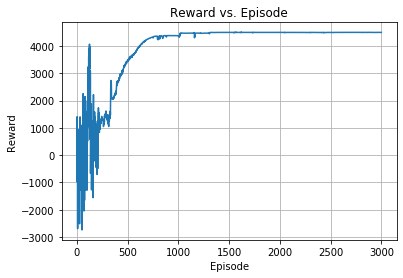

In [14]:
fig, ax = plt.subplots()
ax.plot(epi, Reward)

ax.set(xlabel='Episode', ylabel='Reward',
       title='Reward vs. Episode')
ax.grid()
plt.show()

In [15]:
np.max(Reward)

4505.015681254397